Import Libraries

In [35]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
import torch
import time
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,auc,classification_report,f1_score,precision_score,recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
import joblib
from imblearn.over_sampling import SMOTE
import time
from skorch.callbacks import Checkpoint
from sklearn.metrics import confusion_matrix

In [10]:
#Load pre-processed data
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [12]:
y_test.value_counts()

class
1        2466
0        1315
dtype: int64

In [34]:
#34% Hadron #65.22% Hadron

In [17]:
#Balancing the data
#X_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)

In [18]:
# print(f'before balancing: {y_train.value_counts()}')
# print(f'after balancing: {y_resampled.value_counts()}')

In [19]:
# x_train_over = np.array(X_resampled)
# x_test = np.array(x_test)
# y_train_over = np.array(y_resampled).ravel()
# y_test = np.array(y_test).ravel()


In [20]:
#Converted to numpy array
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [21]:
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

x_train shape: (15124, 9), y_train shape: (15124,), x_test shape: (3781, 9), y_test shape: (3781,)


In [22]:
# print(f'x_train shape: {x_train_over.shape}, y_train shape: {y_train_over.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

In [23]:
#Define input, output and dropout
input_layer = 9 # input is 9 as there are nine predictors
hidden_layers = [50,100] # experimented with different hidden layers list defines first hidden layer has 50 neurons and second has 100
# hidden_layers = [50,100, 120]
# hidden_layers = [10,20]
output_layer = 2 #it is a binary classification, so two perceptrons in output layer
dropout = 0.5 #experimented with different value of dropout -0.5,0.7,0.8

In [24]:
#Define feed forward network
class telescope_net(nn.Module):
    def __init__(self,
                 input_dim = input_layer,
                 hidden_dim = hidden_layers,
                 output_dim = output_layer,
                 dropout = dropout
                ):
        super(telescope_net, self).__init__() #instantiate nn.module
        self.fc1 = nn.Linear(input_layer, hidden_layers[0]) #9 features so input layer has 9 neurons
        self.dropout = nn.Dropout(dropout)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers)-1)])
       
        self.out = nn.Linear(hidden_dim[-1] ,output_layer)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim =-1) #dim -1 as my output is one dimensional
        #self.tanh = nn.Tanh()
      
        
    
    
    def forward(self, x): #x is input
        x = self.relu(self.fc1(x)) #activation function relu is firing 
        x = self.dropout(x)#droput is used to reduce overfitting
        for layer in self.hidden_layers: # performed with for loop to reduce code size
            x = self.relu(layer(x))
            x = self.dropout(x) 
        #x = self.out
        x = self.softmax(self.out(x)) #softmax function firing on output layer, it will give probability of each class(gamma or Hadron)
        
        
        return x

In [25]:
#Not used now as we have considered checkpoint with monitor with best validation loss
# from skorch.callbacks import Callback

# class EarlyStoppingAccuracyThreshold(Callback):
#     def __init__(self, accuracy_threshold):
#         super().__init__()
#         self.accuracy_threshold = accuracy_threshold

#     def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs): #https://skorch.readthedocs.io/en/stable/callbacks.html
#         if dataset_valid is not None:
#             accuracy = net.history[-1, 'valid_acc']
#             if accuracy > self.accuracy_threshold:
#                 print(f"Validation accuracy reached {accuracy*100}%, stopping training.")
#                 raise KeyboardInterrupt


In [26]:
#Defie NeuralNetClassifier
# net = NeuralNetClassifier(
#     telescope_net,
#     criterion = nn.CrossEntropyLoss,
#     lr=0.0003,
#     max_epochs=200,
#     optimizer = torch.optim.SGD,
#     optimizer__weight_decay=0.01,
#     optimizer__momentum=0.98,
    
#    #callbacks=[EarlyStoppingAccuracyThreshold(accuracy_threshold=0.81)],
#     #callbacks = [EarlyStopping(patience = 20)] # experimented with Early stopping with patience value = default(5) and 20 by defining
#  ) 

In [29]:
checkpoint = Checkpoint(monitor='valid_loss_best') #checkpoint is used so that callback will monitor the validation loss and save the 
#model with least loss 

In [30]:
#final Final model 
net = NeuralNetClassifier(
    telescope_net,
    criterion = nn.CrossEntropyLoss,
    #criterion =nn.BCEWithLogitsLoss,
    lr=0.003,
    max_epochs=200,
    optimizer = torch.optim.Adam,
    optimizer__weight_decay=0.001,
    #optimizer__momentum=0.95,
    #callbacks=[EarlyStoppingAccuracyThreshold(accuracy_threshold=0.8740)],
    callbacks = [checkpoint]
 ) 

## x_train

In [32]:
x_train = x_train.astype(np.float32) #Changed datatype of features required for skorch to train the model
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int64)

In [33]:
#Train the model with best hyperparameters with noting down its time
start_time = time.time()
net.fit(x_train,y_train)
end_time = time.time()
elapsed_time = end_time- start_time
print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5451       0.8162        0.4870     +  0.3294
      2        0.4970       0.8327        0.4754     +  0.2611
      3        0.4862       0.8407        0.4661     +  0.2872
      4        0.4779       0.8466        0.4593     +  0.2706
      5        0.4706       0.8588        0.4517     +  0.2526
      6        0.4698       0.8585        0.4511     +  0.2484
      7        0.4649       0.8592        0.4496     +  0.2984
      8        0.4646       0.8605        0.4485     +  0.2782
      9        0.4638       0.8631        0.4477     +  0.2410
     10        0.4620       0.8585        0.4494        0.3253
     11        0.4586       0.8612        0.4460     +  0.2810
     12        0.4617       0.8615        0.4442     +  0.2664
     13        0.4593       0.8664        0.4446        0.2636
     14        0.4598       0.8694        0.4416     + 

    123        0.4561       0.8655        0.4398        0.2821
    124        0.4557       0.8635        0.4427        0.2838
    125        0.4553       0.8621        0.4441        0.2886
    126        0.4569       0.8658        0.4423        0.2789
    127        0.4555       0.8631        0.4425        0.2788
    128        0.4541       0.8635        0.4410        0.2855
    129        0.4551       0.8655        0.4394        0.2994
    130        0.4560       0.8655        0.4416        0.2870
    131        0.4553       0.8674        0.4401        0.2915
    132        0.4557       0.8645        0.4419        0.2778
    133        0.4551       0.8658        0.4412        0.2697
    134        0.4549       0.8658        0.4407        0.2704
    135        0.4564       0.8605        0.4430        0.2870
    136        0.4561       0.8645        0.4396        0.2741
    137        0.4553       0.8688        0.4400        0.2853
    138        0.4541       0.8658        0.4396       

In [291]:
#load the parameters (weights bias etc which has least validation loss)
net.load_params(checkpoint=checkpoint)

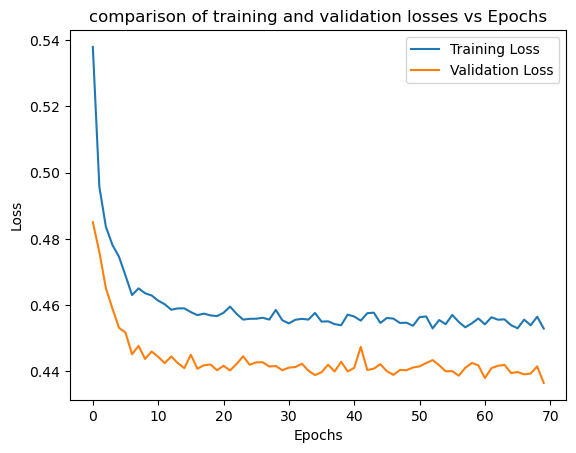

In [292]:
#plot graoh for epoch vs loss obtained during training
training_losses = net.history[:, 'train_loss'] 
validation_losses = net.history[:, 'valid_loss']

plt.plot(np.arange(len(training_losses)), training_losses, label='Training Loss', )
plt.plot(np.arange(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.title('comparison of training and validation losses vs Epochs')
plt.show()

In [244]:
net #check the network

<bound method NeuralNetClassifier.get_loss of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=telescope_net(
    (fc1): Linear(in_features=9, out_features=50, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=50, out_features=100, bias=True)
    )
    (out): Linear(in_features=100, out_features=2, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=-1)
  ),
)>

In [293]:
y_pred = net.predict(x_test) #predict the output
y_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

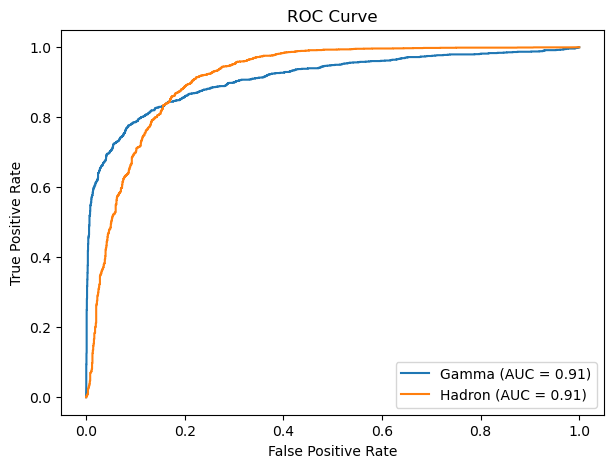

In [294]:
y_pred_prob = net.predict_proba(x_test) # Predict probabilities for both class(gamma and hadron)


fpr_0, tpr_0, _ = roc_curve(y_test, y_pred_prob[:, 0], pos_label=0) # Compute FPR and TPR for creating ROC curve
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
#0 for Hadron and 1 for gamma

roc_auc_class0 = auc(fpr_0, tpr_0)  # Calculate AUC values for both class
roc_auc_class1 = auc(fpr_1, tpr_1)

plt.figure(figsize=(6, 4))  #plot ROC curve for both class

# Plot ROC curve for Hadron (class 0)
plt.plot(fpr_0, tpr_0, label=f'Gamma (AUC = {roc_auc_class0:.2f})')

# Plot ROC curve for Gamma (class 1) 
plt.plot(fpr_1, tpr_1, label=f'Hadron (AUC = {roc_auc_class1:.2f})')


plt.xlabel('False Positive Rate') #set labels
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend() #legends described in label above

# Show the plot
plt.show()


In [295]:

cm_mlp = confusion_matrix(y_test, y_pred) #create confusion matrix

<Axes: >

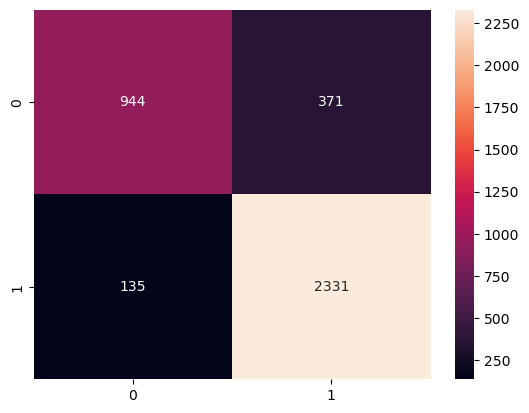

In [296]:
sns.heatmap(cm_mlp, annot= True , fmt='d') # Plot confusion matrix using heatmap

In [297]:
#performance metrics 
accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
precision_score =  precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)

In [298]:
print(f'Accuracy: {accuracy}, F1_score: {f1_score},precision_score: {precision_score},recall_score: {recall_score}')

Accuracy: 0.8661729701137265, F1_score: 0.9020897832817337,precision_score: 0.8626943005181347,recall_score: 0.9452554744525548


In [299]:
#Save best model
#joblib.dump(net, 'MLP_best_model')

['MLP_best_model']